http://fastml.com/predicting-sales-pandas-vs-sql/  

https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html

Use data from [rossmann-store-sales](https://www.kaggle.com/c/rossmann-store-sales) kaggle comp. The point is to predict sales in about a thousand stores across Germany. There are roughly million training points and 40k testing points. The training set spans January 2013 through June 2015, and the test set the next three months in 2015. The data is clean and nice, prepared with German solidity. 

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [17]:
import pandas as pd
import sqlite3

data_dir = '/Users/robincole/Documents/kaggle/rossmann-store-sales'
train_file = f'{data_dir}/train.csv'
test_file = f'{data_dir}/test.csv'
db_file = f'{data_dir}/sales.sqlite'

train = pd.read_csv( train_file )
test = train = pd.read_csv( test_file )
conn = sqlite3.connect( db_file )

## Writ train.csv to sqlite file to allow comparison
train.to_sql('train', conn, index = False, if_exists = 'replace')
test.to_sql('test', conn, index = False, if_exists = 'replace')

/Users/robincole/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Pandas vs SQL
Do various operations in pandas then SQL for comparison

#### Print the head

In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
query = 'SELECT * FROM train LIMIT 5;'
pd.read_sql(query, conn)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


#### Histogram of sales
Easy in Pandas

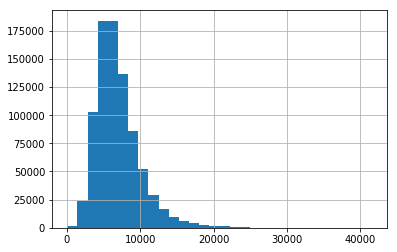

In [6]:
# train.loc[train.Sales > 0, 'Sales'].hist( bins = 30 ) # But i prefer
train[train['Sales'] > 0 ]['Sales'].hist(bins=30);

Not so obvious in SQL, we need to calculate the bins and do a `group by`. I found several solutions online but they each use syntax specific to the database, e.g. mySQAL or [postgresql which has convenience syntax to help](http://www.silota.com/docs/recipes/sql-histogram-summary-frequency-distribution.html)

In [7]:
query = """
SELECT ROUND(sales, -2)    AS bucket,
       COUNT(*)                    AS COUNT,
       RPAD('', LN(COUNT(*)), '*') AS bar
FROM   train
GROUP  BY bucket;
"""

# pd.read_sql(query, conn)

TLDR : win for pandas here for convenience

#### The benchmark - median
The benchmark for the competition **predicts sales for any given store as a median of sales from all stores on the same day of the week**. This means we GROUP BY the day of the week:

In [8]:
medians_by_day = train.groupby(['DayOfWeek']).median()['Sales']

In [9]:
medians_by_day

DayOfWeek
1    7310
2    6463
3    6133
4    6020
5    6434
6    5410
7       0
Name: Sales, dtype: int64

Again there is no simple way to get a median in SQL, [but a few db specific commands](https://stackoverflow.com/questions/1291152/simple-way-to-calculate-median-with-mysql). At least it is simple to get the average

In [10]:
query = """
SELECT DayOfWeek, AVG( Sales ) 
FROM train 
GROUP BY DayOfWeek
"""

pd.read_sql(query, conn)

,DayOfWeek,AVG( Sales )
0,1,7809.044510
1,2,7005.244467
2,3,6555.884138
3,4,6247.575913
4,5,6723.274305
5,6,5847.562599
6,7,204.183189


#### Beating the benchmark - group by store
The obvious way to improve on the benchmark is to group not only by day of week, but also by a store. Even better, we can include other fields, for example Promo. We have enough data to get medians for every possible combination of these three variables.

In [11]:
medians = train.groupby( ['DayOfWeek', 'Store', 'Promo'] )['Sales'].mean()
medians = medians.reset_index() 
medians.head()

,DayOfWeek,Store,Promo,Sales
0,1,1,0,3893.306452
1,1,1,1,5852.708333
2,1,2,0,3921.177419
3,1,2,1,7400.236111
4,1,3,0,5364.016129


In [12]:
query = """
SELECT DayOfWeek, Store, Promo, AVG(Sales) AS AvgSales 
FROM train 
GROUP BY DayOfWeek, Store, Promo
LIMIT 5
"""
pd.read_sql(query, conn)

,DayOfWeek,Store,Promo,AvgSales
0,1,1,0,3893.306452
1,1,1,1,5852.708333
2,1,2,0,3921.177419
3,1,2,1,7400.236111
4,1,3,0,5364.016129


In [ ]:
For the next part we need to create a table, can we do that with pandas?

In [21]:
query = """
CREATE VIEW means AS 
    SELECT DayOfWeek, Store, Promo, AVG( Sales ) AS AvgSales FROM train 
    GROUP BY DayOfWeek, Store, Promo
"""
try:
    pd.read_sql(query, conn)
except:
    pass

#### Merge vs. Join
For when data is spread over two or more tables.

For now, we have the medians/means and want to produce predictions for the test set. Accordingly, there are two data frames, or tables: test and medians/means. For each row in test, we’d like to pull an appropriate median.

In [15]:
test2 = pd.merge( test, medians, on = ['DayOfWeek', 'Store', 'Promo'], how = 'left' )

In [16]:
test2.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,1,4,2015-09-17,1.0,1,0,0,4685.416667
1,2,3,4,2015-09-17,1.0,1,0,0,7550.291667
2,3,7,4,2015-09-17,1.0,1,0,0,9275.666667
3,4,8,4,2015-09-17,1.0,1,0,0,7095.000000
4,5,9,4,2015-09-17,1.0,1,0,0,6401.083333


In [23]:
query = """
SELECT test.*, means.AvgSales AS Sales FROM test LEFT JOIN means ON ( 
    test.DayOfWeek = means.DayOfWeek 
    AND test.Store = means.Store 
    AND test.Promo = means.Promo )
"""
pd.read_sql(query, conn)

DatabaseError: Execution failed on sql '
SELECT test.*, means.AvgSales AS AvgSales FROM test LEFT JOIN means ON ( 
    test.DayOfWeek = means.DayOfWeek 
    AND test.Store = means.Store 
    AND test.Promo = means.Promo )
': no such column: Sales